In [1]:
def read_data(filename):
    with open(filename,'r',encoding = 'UTF8') as f:
        data = [line.split('\t') for line in f.read().splitlines()]
        data = data[1:]
    return data

In [12]:
train_data = read_data("문자열_train_data.txt")
test_data = read_data("문자열_test_data.txt")

In [13]:
from konlpy.tag import Okt # konlpy.tag = 형태소 분석 및 품사 태깅

In [14]:
okt = Okt()
print(okt.pos(u'이 밤 그날의 반딧불을 당신의 창 가까이 보낼게요'))

[('이', 'Noun'), ('밤', 'Noun'), ('그날', 'Noun'), ('의', 'Josa'), ('반딧불', 'Noun'), ('을', 'Josa'), ('당신', 'Noun'), ('의', 'Josa'), ('창', 'Noun'), ('가까이', 'Noun'), ('보낼게요', 'Verb')]


In [15]:
import json
import os
from pprint import pprint

In [16]:
def tokenize(doc):
    return['/'.join(t) for t in okt.pos(doc, norm=True, stem=True)]
# norm -> 정규화 : 그래욬-> 그래요, stem -> 근사화 : 그래요 -> 그렇다

In [19]:
if os.path.isfile('train_docs.json'):
    with open('train_docs.json',encoding="UTF-8")as f:
        train_docs = json.load(f)
    with open('test_docs.json',encoding="UTF-8")as f:
        test_docs = json.load(f)
else:
    train_docs = [(tokenize(row[0]),row[1]) for row in train_data]
    test_docs = [(tokenize(row[0]),row[1]) for row in test_data]
    with open('train_docs.json','w',encoding="UTF-8")as make_file:
        json.dump(train_docs, make_file, ensure_ascii=False, indent="\t")
    with open('test_docs.json','w',encoding="UTF-8")as make_file:
        json.dump(test_docs, make_file, ensure_ascii=False, indent="\t")
        


In [20]:
pprint(train_docs[0])

(['조선인/Noun',
  '위안부/Noun',
  '들/Suffix',
  '을/Josa',
  '구/Noun',
  '하다/Verb',
  '한국/Noun',
  '군/Suffix',
  '이/Josa',
  '도착/Noun',
  '하다/Verb',
  './Punctuation'],
 '1')


In [21]:
tokens = [t for d in train_docs for t in d[0]]
print(len(tokens))

37128


In [22]:
import nltk #natural langauge tool kit - 자연어처리
text = nltk.Text(tokens,name='NMSC')

print(len(text.tokens)) #전체토큰의 수

print(len(set(text.tokens))) #중복을 제외한 토큰의 수

37128
6189


In [23]:
pprint(text.vocab().most_common(10)) #가장 많이나오는 단어출력

[('./Punctuation', 3673),
 ('을/Josa', 1324),
 ('하다/Verb', 1165),
 ('이/Josa', 891),
 ('를/Josa', 781),
 ('는/Josa', 639),
 ('의/Josa', 615),
 ('에/Josa', 601),
 ('가/Josa', 596),
 ('그/Noun', 555)]


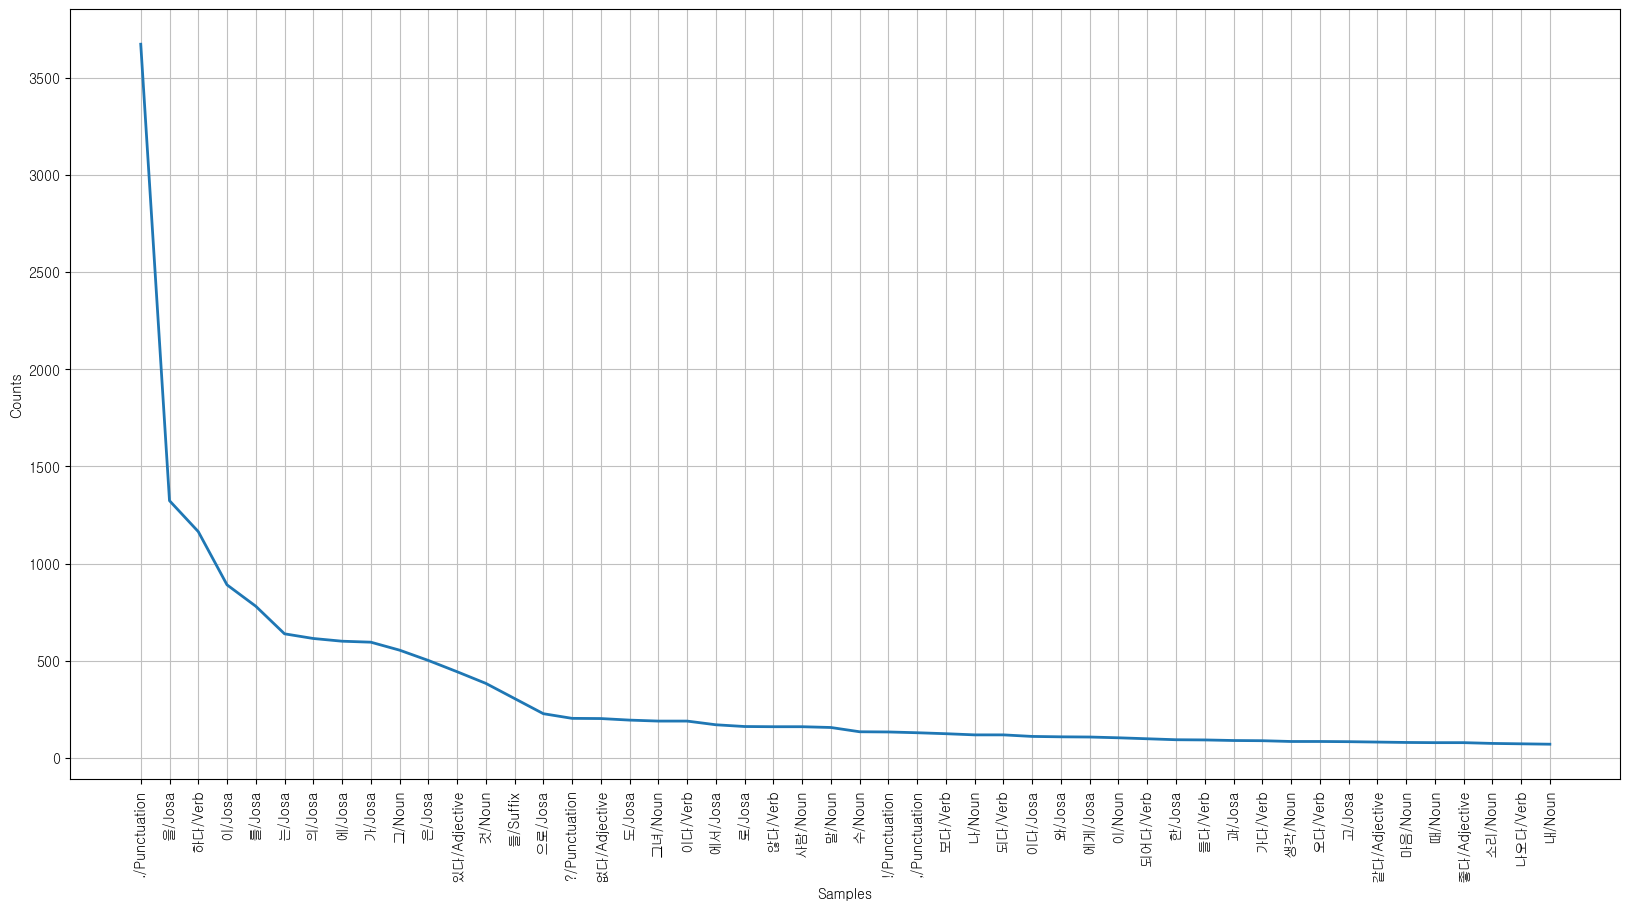

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [24]:
# 가장 많이 나오는 단어 그래프로 출력
import matplotlib.pyplot as plt
from matplotlib import font_manager,rc # 한글 폰트불러오기

font_fname = 'c:/windows/fonts/gulim.ttc'# <-window
# 리눅스 -> /Library/Fonts/AppleGothic.ttf
font_name = font_manager.FontProperties(fname=font_fname).get_name()
rc('font',family=font_name)

plt.figure(figsize=(20,10))
text.plot(50)

In [51]:
selected_words = [f[0] for f in text.vocab().most_common(15000)]
# sample 크기가 너무 크면 밑에 메모리 오류로 실행이 안됨 5000까지는 돌아감
def term_frequency(doc):
    return [doc.count(word) for word in selected_words]

train_x = [term_frequency(d) for d, _ in train_docs]
test_x = [term_frequency(d) for d, _ in test_docs]
train_y = [c for _,c in train_docs]
test_y = [c for _, c in test_docs]

In [52]:
# 데이터를 float형으로 변환
import numpy as np

x_train = np.array(train_x).astype('float32')
x_test = np.array(test_x).astype('float32')

y_train = np.array(train_y).astype('float32')
y_test = np.array(test_y).astype('float32')

In [53]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import metrics

model = models.Sequential()
model.add(layers.Dense(64,activation='relu',input_shape=(6189,)))
model.add(layers.Dense(64,activation='relu'))
model.add(layers.Dense(1,activation='sigmoid'))

model.compile(optimizer = optimizers.RMSprop(lr=0.001),
             loss = losses.binary_crossentropy, # 손실 함수
             metrics = [metrics.binary_accuracy])

model.fit(x_train, y_train,epochs=10,batch_size=512) # 에포크 = 10, 배치 사이즈 = 512
results = model.evaluate(x_test,y_test)

Epoch 1/10
8/8 [==============================] - 0s 5ms/step - loss: 0.6873 - binary_accuracy: 0.5778
Epoch 2/10
8/8 [==============================] - 0s 5ms/step - loss: 0.6310 - binary_accuracy: 0.7878
Epoch 3/10
8/8 [==============================] - 0s 6ms/step - loss: 0.5373 - binary_accuracy: 0.8428
Epoch 4/10
8/8 [==============================] - 0s 5ms/step - loss: 0.4362 - binary_accuracy: 0.8763
Epoch 5/10
8/8 [==============================] - 0s 5ms/step - loss: 0.3479 - binary_accuracy: 0.9078
Epoch 6/10
8/8 [==============================] - 0s 5ms/step - loss: 0.2770 - binary_accuracy: 0.9285
Epoch 7/10
8/8 [==============================] - 0s 4ms/step - loss: 0.2200 - binary_accuracy: 0.9480
Epoch 8/10
8/8 [==============================] - 0s 5ms/step - loss: 0.1757 - binary_accuracy: 0.9560
Epoch 9/10
8/8 [==============================] - 0s 25ms/step - loss: 0.1397 - binary_accuracy: 0.9668
Epoch 10/10
13/13 [==============================] - 0s 1ms/step - loss:

In [54]:
results

[0.2949727773666382, 0.8675000071525574]

In [55]:
def predict_pos_neg(review):
    token = tokenize(review)
    tf = term_frequency(token)
    data = np.expand_dims(np.array(tf).astype('float32'),axis=0)
    score = float(model.predict(data))
    if(score>0.5):
        print("오늘의 긍정지수는 {:2f}%입니다.\n".format(score*100))
    else:
        print("오늘의 부정지수는 {:2f}%입니다.\n".format((1-score)*100))

In [57]:
predict_pos_neg("나 오늘 여자친구랑 헤어졌어.")
predict_pos_neg("이승렬 진짜 잘생겼다...너무 설레는데.")
predict_pos_neg("오늘 하루는 비가 너무 많이 온다.")
predict_pos_neg("나 오늘 좀 아픈거 같아.")
predict_pos_neg("하하하.")
predict_pos_neg("오늘은 날씨가 좋은게 좋은일이 있으려나.")
predict_pos_neg("이게 진정한 행복이지 않을까?")
predict_pos_neg("민창 오늘도 고생했어 내일도 고생 좀 해.")

1/1 [==============================] - 0s 12ms/step
오늘의 부정지수는 81.864625%입니다.

1/1 [==============================] - 0s 12ms/step
오늘의 긍정지수는 75.396037%입니다.

1/1 [==============================] - 0s 12ms/step
오늘의 긍정지수는 65.951037%입니다.

1/1 [==============================] - 0s 12ms/step
오늘의 부정지수는 99.197755%입니다.

1/1 [==============================] - 0s 12ms/step
오늘의 긍정지수는 92.195010%입니다.

1/1 [==============================] - 0s 12ms/step
오늘의 긍정지수는 99.405342%입니다.

1/1 [==============================] - 0s 12ms/step
오늘의 부정지수는 71.370879%입니다.

1/1 [==============================] - 0s 11ms/step
오늘의 부정지수는 86.996892%입니다.

